In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import time

from tensorflow.python.keras.backend import set_session
from tqdm import tqdm
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

2025-03-18 15:57:12.274203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 15:57:12.274249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 15:57:12.312094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 15:57:12.390838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-18 15:57:13.196139: W tensorflow/compiler/tf2

In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:19<00:00, 43.89it/s]


In [4]:
# Create ImageDataGenerator for Data Augmentation
data_genX = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=2.5,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    zoom_range=0.075,
    horizontal_flip=True,
)

In [5]:
# Create ImageDataGenerator for Data Augmentation
data_genY = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=2.5,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    zoom_range=0.075,
    horizontal_flip=True,
)

In [6]:
# Generate additional images to equalize classes if necessary
def generate(X_all, y_all):

# Generation
    X_generated = []
    y_generated = []
    
    data_gen.fit(X_all)
    
    generated_images = data_gen.flow(X_all, y_all, batch_size=1)
    
    for _ in range(len(X_all)):
        X_new, y_new = next(generated_images)
        X_generated.append(np.squeeze(X_new))
        y_generated.append(np.squeeze(y_new))

    print(f'New images generated: {len(X_generated)}')

    return X_generated, y_generated

In [7]:
#X_new, y_new = generate(X, y)

In [8]:
def plot_images(images, images_per_figure=100):
    num_images = len(images)
    cols = 5
    rows = (images_per_figure + cols - 1) // cols

    for start in range(0, num_images, images_per_figure):
        plt.figure(figsize=(cols * 3, rows * 3))
        end = min(start + images_per_figure, num_images)

        for i in range(start, end):
            plt.subplot(rows, cols, i - start + 1)
            plt.imshow(images[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [9]:
#plot_images(X_new)

In [10]:
#X_new = np.expand_dims(X_new, axis=-1)
#print('X_new: ', X_new.shape)

In [11]:
def unet():
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
     
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
     
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
     
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)
    
     
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)
    
     
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)
     
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.ReLU()(u9)
    
     
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

    return model

3


2025-03-18 15:57:34.487023: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-18 15:57:34.634975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-18 15:57:34.635012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-18 15:57:34.636421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-18 15:57:34.636455: I external/local_xla/xla/stream_executor

Epoch 1/300


2025-03-18 15:57:37.254763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-18 15:57:37.573652: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-18 15:57:41.337712: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb3981ed460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-18 15:57:41.337742: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-18 15:57:41.349346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742324261.426695  278722 device_compiler.h:186] Compiled cluster using XLA!  T

41/41 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.9012 - recall: 0.6247
Epoch 1: val_recall improved from -inf to 0.71515, saving model to model_3fold.keras
41/41 [==============================] - 36s 378ms/step - loss: 0.4698 - accuracy: 0.9012 - recall: 0.6247 - val_loss: 0.5418 - val_accuracy: 0.8169 - val_recall: 0.7151
Epoch 2/300
41/41 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9960 - recall: 0.8609
Epoch 2: val_recall did not improve from 0.71515
41/41 [==============================] - 22s 216ms/step - loss: 0.1894 - accuracy: 0.9960 - recall: 0.8609 - val_loss: 0.2302 - val_accuracy: 0.9963 - val_recall: 0.5355
Epoch 3/300
41/41 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9981 - recall: 0.8855
Epoch 3: val_recall did not improve from 0.71515
41/41 [==============================] - 9s 215ms/step - loss: 0.1219 - accuracy: 0.9981 - recall: 0.8855 - val_loss: 0.1445 - val_accuracy: 0.9992 - val

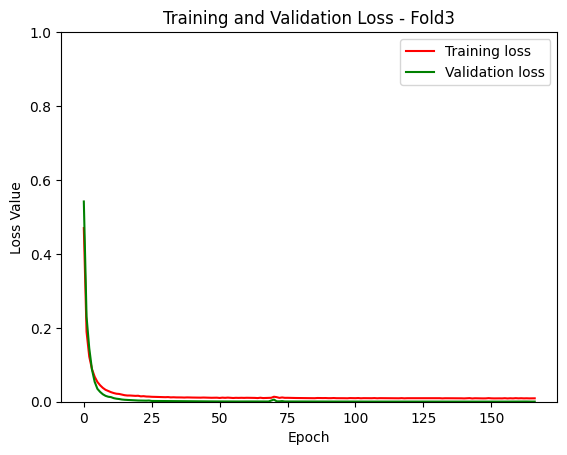

O modelo demorou 1541.91 segundos para treinar.
4
Epoch 1/300


2025-03-18 16:23:18.402631: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.8773 - recall: 0.6428
Epoch 1: val_recall improved from -inf to 0.95058, saving model to model_4fold.keras
41/41 [==============================] - 13s 233ms/step - loss: 0.6038 - accuracy: 0.8773 - recall: 0.6428 - val_loss: 0.6471 - val_accuracy: 0.8439 - val_recall: 0.9506
Epoch 2/300
41/41 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.9927 - recall: 0.8658
Epoch 2: val_recall improved from 0.95058 to 0.99976, saving model to model_4fold.keras
41/41 [==============================] - 9s 219ms/step - loss: 0.3257 - accuracy: 0.9927 - recall: 0.8658 - val_loss: 0.5267 - val_accuracy: 0.8951 - val_recall: 0.9998
Epoch 3/300
41/41 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9972 - recall: 0.8786
Epoch 3: val_recall did not improve from 0.99976
41/41 [==============================] - 9s 214ms/step - loss: 0.2125 - accuracy: 0.9972 - recall: 0.8786 - val_los

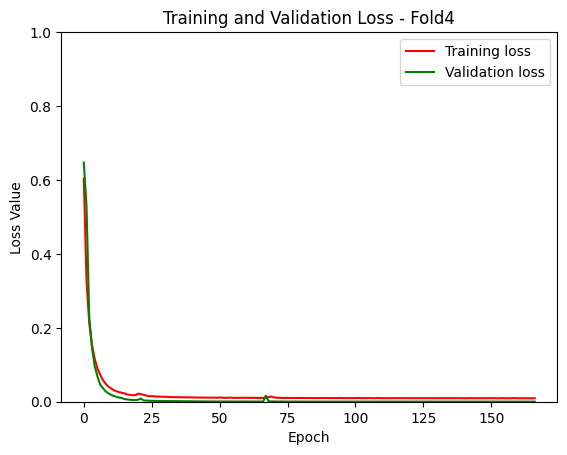

O modelo demorou 1499.14 segundos para treinar.
5
Epoch 1/300


2025-03-18 16:48:17.521321: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.8533 - recall: 0.6021
Epoch 1: val_recall improved from -inf to 0.99993, saving model to model_5fold.keras
41/41 [==============================] - 13s 230ms/step - loss: 0.6303 - accuracy: 0.8533 - recall: 0.6021 - val_loss: 2.8913 - val_accuracy: 0.4057 - val_recall: 0.9999
Epoch 2/300
41/41 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.9917 - recall: 0.8371
Epoch 2: val_recall did not improve from 0.99993
41/41 [==============================] - 9s 213ms/step - loss: 0.3369 - accuracy: 0.9917 - recall: 0.8371 - val_loss: 0.5111 - val_accuracy: 0.9021 - val_recall: 0.8539
Epoch 3/300
41/41 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9969 - recall: 0.8794
Epoch 3: val_recall did not improve from 0.99993
41/41 [==============================] - 9s 213ms/step - loss: 0.2104 - accuracy: 0.9969 - recall: 0.8794 - val_loss: 0.2453 - val_accuracy: 0.9984 - val_

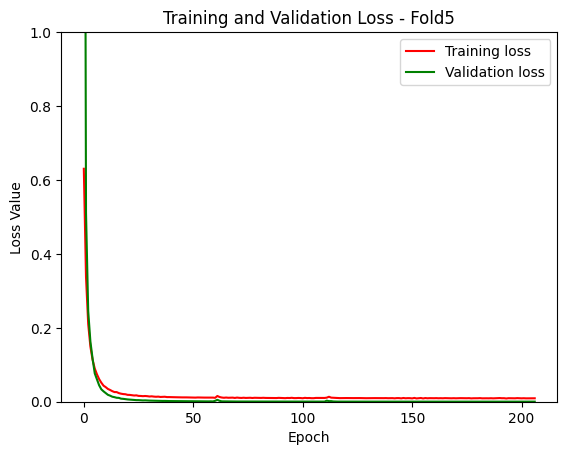

O modelo demorou 1858.16 segundos para treinar.
6


IndexError: list index out of range

In [12]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

kf = KFold(n_splits=k, shuffle=True, random_state=28)
fold = 1
seed = [42, 21, 5, 10, 72]
for train_ind, test_ind in kf.split(X):
    start_time = time.time()
    
    print("Fold: " +str(fold))
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
    #y_train = y_train.astype('float')
    #y_val = y_val.astype('float')
    model = unet()
    
    checkpoint_filepath = 'model_' + str(fold)+'fold.keras'
    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_recall',
                mode='max',
                save_best_only=True,
                verbose=1)]

    image_generator = data_genX.flow(X_train, batch_size=16, seed=seed[fold-1])
    mask_generator = data_genY.flow(y_train, batch_size=16, seed=seed[fold-1])
    
    # Criar um gerador que produza (imagem, máscara) no mesmo passo
    train_generator = zip(image_generator, mask_generator)
    
    model.fit(train_generator, steps_per_epoch=len(X_train) // 16, validation_data=(X_val,y_val), epochs=300, callbacks=callbacks, class_weight={0:1.0, 1:100.0})
    model.save('model_' + str(fold)+'fold.keras')
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    plt.figure()
    plt.plot( loss, 'r', label='Training loss')
    plt.plot( val_loss, 'g', label='Validation loss')
    plt.title('Training and Validation Loss - Fold' + str(fold))
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc.append(accuracy_score(sample_mask, predicted_mask))
        jacc.append(jaccard_score(sample_mask, predicted_mask))
        f1.append(f1_score(sample_mask, predicted_mask))
        prec.append(precision_score(sample_mask, predicted_mask))
        rec.append(recall_score(sample_mask, predicted_mask))

    end_time = time.time()
    training_time = end_time - start_time

    with open('UNet_5-fold_DA_tempo.txt', 'a') as f:
        f.write(f'{training_time:.2f}\n')
    print(f"O modelo demorou {training_time:.2f} segundos para treinar.")
    
    del model

    tf.keras.backend.clear_session()
    
    fold+=1
    
print("Accuracy: "+ str(np.mean(acc)) + "+- " + str(np.std(acc)))
print("Jaccard: "+ str(np.mean(jacc)) + "+- " + str(np.std(jacc)))
print("Dice: "+ str(np.mean(f1)) + "+- " + str(np.std(f1)))
print("Precision: "+ str(np.mean(prec)) + "+- " + str(np.std(prec)))
print("Recall: "+ str(np.mean(rec)) + "+- " + str(np.std(rec)))

In [ ]:
print("Accuracy: "+ str(np.mean(acc)) + "+- " + str(np.std(acc)))
print("Jaccard: "+ str(np.mean(jacc)) + "+- " + str(np.std(jacc)))
print("Dice: "+ str(np.mean(f1)) + "+- " + str(np.std(f1)))
print("Precision: "+ str(np.mean(prec)) + "+- " + str(np.std(prec)));
print("Recall: "+ str(np.mean(rec)) + "+- " + str(np.std(rec)))

In [13]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


f = 0
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    acc= []
    jacc = []
    f1 = []
    prec = []
    rec = []
    
    model = tf.keras.models.load_model('model_'+str(f+1)+'fold.keras')

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc.append(accuracy_score(sample_mask, predicted_mask))
        jacc.append(jaccard_score(sample_mask, predicted_mask))
        f1.append(f1_score(sample_mask, predicted_mask))
        prec.append(precision_score(sample_mask, predicted_mask))
        rec.append(recall_score(sample_mask, predicted_mask))

    acc_mean_fold.append(np.mean(acc))
    acc_std_fold.append(np.std(acc))
    jacc_mean_fold.append(np.mean(jacc))
    jacc_std_fold.append(np.std(jacc))
    f1_mean_fold.append(np.mean(f1))
    f1_std_fold.append(np.std(f1))
    prec_mean_fold.append(np.mean(prec))
    prec_std_fold.append(np.std(prec))
    rec_mean_fold.append(np.mean(rec))
    rec_std_fold.append(np.std(rec))
    
    print("Model - Fold" + str(f+1)+ "Accuracy: " + str(acc_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Jaccard: " + str(jacc_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Dice: " + str(f1_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Precision: " + str(prec_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Recall: " + str(rec_mean_fold[-1]))

    f += 1

k-fold:  20%|███████████████▍                                                             | 1/5 [00:24<01:37, 24.36s/it]

Model - Fold1Accuracy: 0.9998332205272856
Model - Fold1Jaccard: 0.797679220397353
Model - Fold1Dice: 0.8652199847413327
Model - Fold1Precision: 0.8067183037676882
Model - Fold1Recall: 0.9869543514378696


k-fold:  40%|██████████████████████████████▊                                              | 2/5 [00:47<01:11, 23.82s/it]

Model - Fold2Accuracy: 0.9999311765034994
Model - Fold2Jaccard: 0.850571345287886
Model - Fold2Dice: 0.909123651935019
Model - Fold2Precision: 0.8597746761185535
Model - Fold2Recall: 0.9864512200547547


k-fold:  60%|██████████████████████████████████████████████▏                              | 3/5 [01:11<00:47, 23.89s/it]

Model - Fold3Accuracy: 0.9999087651570638
Model - Fold3Jaccard: 0.8197466327107248
Model - Fold3Dice: 0.8970688784103072
Model - Fold3Precision: 0.8212082063962521
Model - Fold3Recall: 0.9981117421060341


k-fold:  80%|█████████████████████████████████████████████████████████████▌               | 4/5 [01:35<00:23, 23.86s/it]

Model - Fold4Accuracy: 0.9999190233424752
Model - Fold4Jaccard: 0.8415306707852671
Model - Fold4Dice: 0.9107910140584718
Model - Fold4Precision: 0.8430446736451888
Model - Fold4Recall: 0.9979764773514975


k-fold: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.04s/it]

Model - Fold5Accuracy: 0.9999242542746538
Model - Fold5Jaccard: 0.8252530805828915
Model - Fold5Dice: 0.897495920236582
Model - Fold5Precision: 0.8263897678640909
Model - Fold5Recall: 0.9978095604302831


In [14]:
print("Accuracy: "+ str(np.mean(acc_mean_fold)*100) + " +- " + str(np.std(acc_std_fold)*100))
print("Jaccard: "+ str(np.mean(jacc_mean_fold)*100) + " +- " + str(np.std(jacc_std_fold)*100))
print("Dice: "+ str(np.mean(f1_mean_fold)*100) + " +- " + str(np.std(f1_std_fold)*100))
print("Precision: "+ str(np.mean(prec_mean_fold)*100) + " +- " + str(np.std(prec_std_fold)*100))
print("Recall: "+ str(np.mean(rec_mean_fold)*100) + " +- " + str(np.std(rec_std_fold)*100))

Accuracy: 99.99032879609956 +- 0.009783406740455454
Jaccard: 82.69561899528244 +- 4.39055092476963
Dice: 89.59398898763425 +- 4.534186950052695
Precision: 83.14271255583547 +- 4.497262400857257
Recall: 99.34606702760877 +- 0.749514875198207


In [15]:
best_model = tf.keras.models.load_model('model_5fold.keras')

In [16]:

kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == 4:
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

1/1 [==============================] - 0s 15ms/step


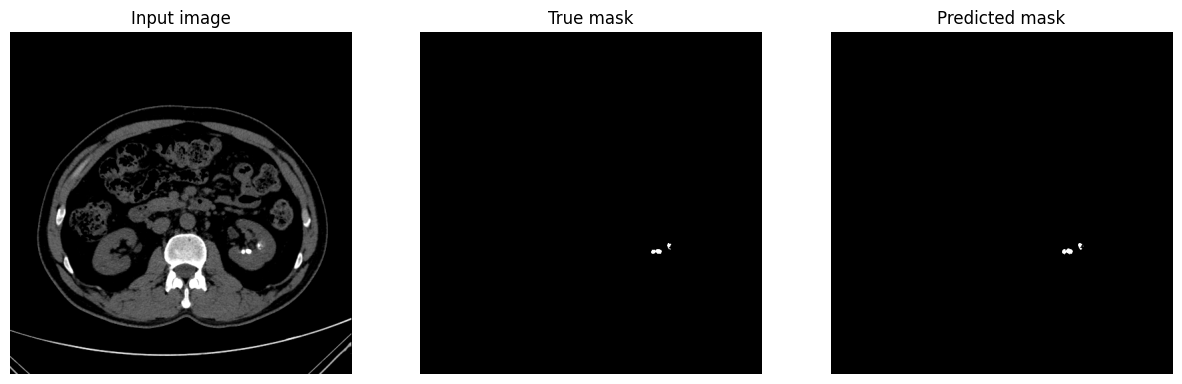

Accuracy: 0.9999198913574219
Jaccard: 0.851063829787234
Dice: 0.9195402298850576
Precision: 0.8571428571428571
Recall: 0.9917355371900827


In [28]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))